# Galerkin block assembly efficiency and precision demo

In [1]:
from kl_decomposition import galerkin
import numpy as np
import pandas as pd
import time

# ----------------------------------------
# Benchmark configuration
# ----------------------------------------

f_vals = [1e1, 1e4, 1e7, 1e10]          # sweep these values
size_of_basis = 60                      # number of polynomials, i.e. polynomial degree - 1

time_budget = 1.0    # seconds per micro-benchmark (wall-clock window)
time_cap = 0.1        # *median* build-time threshold – if exceeded, stop increasing quad
max_repeats = 100     # max iterations per micro-benchmark to avoid infinite loops

# Quadrature sizes to test (ascending so "break" works)
quad_points_duffy = list(range(10, 100, 1)) + list(range(100, 500, 10))
quad_points_gauss = (
    list(range(10, 100, 1))
    + list(range(100, 500, 10))
    + list(range(500, 4000, 50))
)

g_values = [1, 2, 3, 4, 5]    # g-parameters for Duffy mapping

# ----------------------------------------
# Main benchmark loops
# ----------------------------------------

results = []  # collected as (f, gx, gy, quad, err, median_time)

for f_val in f_vals:
    # Build a high-fidelity reference matrix (fixed mapping & dense quadrature)
    A_ref = galerkin.assemble_duffy(
        f=f_val, degree=size_of_basis, quad=1000, gx=4.0, gy=4.0
    )
    A_ref_norm = np.linalg.norm(A_ref)

    # =====================================================
    # Duffy assembly tests – skip larger quad once too slow
    # =====================================================
    for gx in g_values:
        for quad in quad_points_duffy:
            # --------------------
            # Micro-benchmark block
            # --------------------
            durations = []
            t_window_start = time.perf_counter()

            while (time.perf_counter() - t_window_start) < time_budget:
                if len(durations) >= max_repeats:
                    break
                t0 = time.perf_counter()
                A_duf = galerkin.assemble_duffy(
                    f=f_val, degree=size_of_basis, quad=quad, gx=gx, gy=gx
                )
                durations.append(time.perf_counter() - t0)

            median_time = float(np.median(durations))
            err = np.linalg.norm(A_duf - A_ref)
            results.append((f_val, gx, gx, quad, err, median_time))
            print(
                f"[f={f_val:.1e}] Duffy gx={gx:.1f}, quad={quad} "
                f"-> err={err:.2e}, median={median_time:.3f}s"
            )

            # Early-exit logic (uses median time)
            if median_time > time_cap:
                print(
                    f"      ↳ median {median_time:.2f}s > {time_cap}s – skipping larger quads for gx={gx}"
                )
                break  # exit quad loop, continue with next gx
            if err / A_ref_norm < 1e-12:
                print(
                    f"      ↳ error {err:.2e} / {A_ref_norm:.2e} < 1e-12 – skipping larger quads for gx={gx}"
                )
                break

    # =====================================================
    # Gauss-Legendre 2-D tests – same early exit logic
    # =====================================================
    for quad in quad_points_gauss:
        durations = []
        t_window_start = time.perf_counter()

        while (time.perf_counter() - t_window_start) < time_budget:
            if len(durations) >= max_repeats:
                break
            t0 = time.perf_counter()
            A_gauss = galerkin.assemble_gauss2d(
                f=f_val, degree=size_of_basis, quad=quad
            )
            durations.append(time.perf_counter() - t0)

        median_time = float(np.median(durations))
        err = np.linalg.norm(A_gauss - A_ref)
        results.append((f_val, np.nan, np.nan, quad, err, median_time))
        print(
            f"[f={f_val:.1e}] Gauss2D quad={quad} "
            f"-> err={err:.2e}, median={median_time:.3f}s"
        )

        if median_time > time_cap:
            print(
                f"      ↳ median {median_time:.2f}s > {time_cap}s – skipping larger Gauss quad values"
            )
            break
        if err / A_ref_norm < 1e-12:
            print(
                f"      ↳ error {err:.2e} / {A_ref_norm:.2e} < 1e-12 – skipping larger Gauss quad values"
            )
            break

# ----------------------------------------
# Persist results for later analysis
# ----------------------------------------

df = pd.DataFrame(
    results,
    columns=["f", "gx", "gy", "quad", "frobenius_error", "median_time_sec"],
)

df.to_csv("data/duffy_precision_test_60.csv", index=False)
print("Results saved to duffy_precision_test.csv")

[f=1.0e+01] Duffy gx=1.0, quad=10 -> err=2.15e+00, median=0.001s
[f=1.0e+01] Duffy gx=1.0, quad=11 -> err=1.96e+00, median=0.001s
[f=1.0e+01] Duffy gx=1.0, quad=12 -> err=1.85e+00, median=0.001s
[f=1.0e+01] Duffy gx=1.0, quad=13 -> err=1.73e+00, median=0.001s
[f=1.0e+01] Duffy gx=1.0, quad=14 -> err=1.60e+00, median=0.001s
[f=1.0e+01] Duffy gx=1.0, quad=15 -> err=1.33e+00, median=0.001s
[f=1.0e+01] Duffy gx=1.0, quad=16 -> err=1.22e+00, median=0.001s
[f=1.0e+01] Duffy gx=1.0, quad=17 -> err=1.15e+00, median=0.001s
[f=1.0e+01] Duffy gx=1.0, quad=18 -> err=1.10e+00, median=0.001s
[f=1.0e+01] Duffy gx=1.0, quad=19 -> err=1.06e+00, median=0.001s
[f=1.0e+01] Duffy gx=1.0, quad=20 -> err=1.01e+00, median=0.001s
[f=1.0e+01] Duffy gx=1.0, quad=21 -> err=9.72e-01, median=0.001s
[f=1.0e+01] Duffy gx=1.0, quad=22 -> err=9.38e-01, median=0.001s
[f=1.0e+01] Duffy gx=1.0, quad=23 -> err=9.10e-01, median=0.001s
[f=1.0e+01] Duffy gx=1.0, quad=24 -> err=8.93e-01, median=0.001s
[f=1.0e+01] Duffy gx=1.0,

# Plots the results from exported CSV

Saved figure to duffy_precision_plots_time_30_relative.pdf


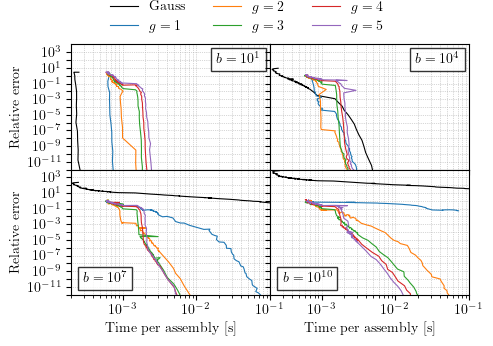

In [56]:
# duffy_precision_plots_time_relative.py
# ======================================
# Compact 2×2 log-log plots with fixed limits for relative errors

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# Matplotlib / LaTeX styling
# ---------------------------------------------------------------------
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.size": 10,
        "axes.labelsize": 10,
        "legend.fontsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
    }
)

# ---------------------------------------------------------------------
# Load data
# ---------------------------------------------------------------------
df = pd.read_csv("data/duffy_precision_test_30.csv")

f_vals = sorted(df["f"].unique())          # 10¹, 10⁴, 10⁷, 10¹⁰
g_values = [1, 2, 3, 4, 5]
colors_g = plt.rcParams["axes.prop_cycle"].by_key()["color"][: len(g_values)]

# Reference norms for each f_val
reference_norms = {
    1e1: 5.89e-01,
    1e4: 1.03e-01,
    1e7: 4.30e-03,
    1e10: 1.37e-04,
}

# ---------------------------------------------------------------------
# Figure: 2 × 2 shared-axis grid
# ---------------------------------------------------------------------
fig, axes = plt.subplots(
    2, 2,
    figsize=(4.35, 3.05),
    sharex=True,
    sharey=True
)

fig.subplots_adjust(
    wspace=0.00, hspace=0.00,
    left=0.08, right=0.995,
    bottom=0.08, top=0.90
)

handles_master, labels_master = [], []

for idx, (ax, f_val) in enumerate(zip(axes.flat, f_vals)):
    sub = df[df["f"] == f_val]
    ref_norm = reference_norms[f_val]

    # --- Gauss (gx NaN) -------------------------------------------------
    gauss = sub[sub["gx"].isna()]
    if not gauss.empty:
        (h_gauss,) = ax.plot(
            gauss["median_time_sec"], gauss["frobenius_error"] / ref_norm,
            "-", lw=0.8, color="black", label="Gauss"
        )
        if not handles_master:
            handles_master.append(h_gauss)
            labels_master.append("Gauss")

    # --- Duffy, coloured by g ------------------------------------------
    for g, color in zip(g_values, colors_g):
        dat = sub[sub["gx"] == g]
        if dat.empty:
            continue
        (h,) = ax.plot(
            dat["median_time_sec"], dat["frobenius_error"] / ref_norm,
            "-", lw=0.8, color=color, label=fr"$g={g}$"
        )
        if idx == 0:
            handles_master.append(h)
            labels_master.append(fr"$g={g}$")

    # --- Common log-log limits -----------------------------------------
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(2e-4, 0.1)
    ax.set_ylim(1e-12, 10000)
    ax.grid(True, which="both", ls=":", lw=0.5)

    # --- Axis labels / tick labels -------------------------------------
    col = idx % 2
    row = idx // 2
    yticks = 10.0 ** np.arange(-12, 4)
    yticklabels = [
        fr"$10^{{{exp}}}$" if (exp % 2 == 1 and exp < 5) else "" for exp in range(-12, 4)
    ]
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)

    if col == 0:
        ax.set_ylabel("Relative error")
    else:
        ax.tick_params(labelleft=False)

    if row == 1:
        ax.set_xlabel("Time per assembly [s]")
    else:
        ax.tick_params(labelbottom=False)

    # --- Corner text ----------------------------------------------------
    exponent = int(np.log10(f_val))
    if idx < 2:
        ax.text(
            0.95, 0.93,
            fr"$b = 10^{{{exponent}}}$",
            transform=ax.transAxes,
            ha="right", va="top",
            bbox=dict(facecolor="white", edgecolor="k", pad=3.9, alpha=0.8)
        )
    elif idx == 2:
        ax.text(
            0.28, 0.18,
            fr"$b = 10^{{{exponent}}}$",
            transform=ax.transAxes,
            ha="right", va="top",
            bbox=dict(facecolor="white", edgecolor="k", pad=3.9, alpha=0.8)
        )
    else:  # idx == 3
        ax.text(
            0.31, 0.18,
            fr"$b = 10^{{{exponent}}}$",
            transform=ax.transAxes,
            ha="right", va="top",
            bbox=dict(facecolor="white", edgecolor="k", pad=3.9, alpha=0.8)
        )
# ---------------------------------------------------------------------
# Legend across top
# ---------------------------------------------------------------------
fig.legend(
    handles_master,
    labels_master,
    loc="upper center",
    ncol=3,
    frameon=False,
    borderaxespad=-0.3,
)

fig.savefig("duffy_precision_plots_time_30_relative.pdf", bbox_inches="tight", pad_inches=0)
print("Saved figure to duffy_precision_plots_time_30_relative.pdf")
plt.show()